# Model performance with stemming

In [1]:
from tensorflow.keras import layers
import keras
from keras import callbacks
from article_common import *

reduce_nondeterminism()

params = {
    "batch_size_power": 5,
    "max_features": 26271,
    "embedding_dim_power": 7,
    "sequence_length": 746,
    "lstm1_units_power": 6,
    "dropout1": 0.060021668616407585,
    "lstm2_units_power": 7,
    "dropout2": 0.34177726017643506
    }

def two_layers_lstm(max_features=20000, embedding_dim=128, lstm1_units=64, dropout1=0.0, lstm2_units=64, dropout2=0.0):
    inputs = tf.keras.Input(shape=(None,), dtype="int64")

    x = layers.Embedding(max_features, embedding_dim)(inputs)

    x = layers.Bidirectional(layers.LSTM(lstm1_units, return_sequences=True, dropout=dropout1))(x)
    x = layers.Bidirectional(layers.LSTM(lstm2_units, dropout=dropout2))(x)

    predictions = layers.Dense(3, activation="softmax", name="predictions")(x)

    model = tf.keras.Model(inputs, predictions)
    return model

import pandas as pd
import numpy as np

df = pd.read_csv("Tweets.csv")
simple_df = df.loc[:, ["text", "airline_sentiment"]]
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(simple_df["airline_sentiment"])
simple_df.loc[:,"sentiment_encoded"] = le.transform(simple_df["airline_sentiment"])

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

def split_to_tensors(column_name):
    X_train, X_test, y_train, y_test = train_test_split(
        simple_df[column_name], simple_df['sentiment_encoded'], test_size=0.1, random_state=42, stratify=simple_df['sentiment_encoded'])
    y_train = np_utils.to_categorical(y_train)
    y_test = np_utils.to_categorical(y_test)
    
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    return train_ds, test_ds

import tensorflow as tf
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

train_ds, test_ds = split_to_tensors("text")

BATCH_SIZE = 128

train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

print(f"Number of batches in train_ds: {train_ds.cardinality()}")
print(f"Number of batches in test_ds: {test_ds.cardinality()}")

from tensorflow.keras.layers import TextVectorization
import string
import re

def get_adapted_vectorizer(train_ds, max_features=20000, embedding_dim=128, sequence_length=500, standardize="lower_and_strip_punctuation"):
    vectorize_layer = TextVectorization(
        max_tokens=max_features,
        output_mode="int",
        output_sequence_length=sequence_length,
        standardize=standardize
    )
    
    text_ds = train_ds.map(lambda x, y: x)

    #Train Vectorizer
    vectorize_layer.adapt(text_ds)
    return vectorize_layer


vectorize_layer = get_adapted_vectorizer(train_ds, standardize=None)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
vectorized_train_ds = train_ds.map(vectorize_text)
vectorized_test_ds = test_ds.map(vectorize_text)

       
import nltk

def count_word_occurrences(word_nested_list):
    counts = dict()
    for word_list in word_nested_list:
        for word in word_list:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    return counts

counts = count_word_occurrences(simple_df['text'].apply(nltk.word_tokenize))

def prepare_singleton_list(counts):
    return list({ word:count for (word,count) in counts.items() if count == 1}.keys())

singletons = prepare_singleton_list(counts)
simple_df.loc[:,'stop_text'] = simple_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in singletons]))

train_ds, test_ds = split_to_tensors("stop_text")

train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

vectorize_layer = get_adapted_vectorizer(train_ds)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
vectorized_train_ds = train_ds.map(vectorize_text)
vectorized_test_ds = test_ds.map(vectorize_text)

vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=10)
vectorized_test_ds = vectorized_test_ds.cache().prefetch(buffer_size=10)

def clean_text(text):
    text = re.sub(r"what's", "what is ", text) # "what's" -> "what is"
    text = re.sub(r"What's", "What is ", text)
    text = re.sub(r"\'ve", " have ", text)  # "You've" -> "You have"
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"Can't", "Cannot ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"I'm", "I am ", text)
    text = re.sub(r"\'re", " are ", text) # "'re" -> " are"
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)  # "I'll" -> 'I will'
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"hrs", "hours", text)
    return text

simple_df["text_ct"] = simple_df["text"].apply(lambda text: clean_text(text))

counts = count_word_occurrences(simple_df['text_ct'].apply(nltk.word_tokenize))

singletons = prepare_singleton_list(counts)
simple_df.loc[:,'stop_text_ct'] = simple_df['text_ct'].apply(lambda x: ' '.join([word for word in x.split() if word not in singletons]))

train_ds, test_ds = split_to_tensors("stop_text_ct")

train_ds = train_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

vectorize_layer = get_adapted_vectorizer(train_ds)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Vectorize the data.
vectorized_train_ds = train_ds.map(vectorize_text)
vectorized_test_ds = test_ds.map(vectorize_text)

vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=10)
vectorized_test_ds = vectorized_test_ds.cache().prefetch(buffer_size=10)

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer
def stemming(text):
    ps = PorterStemmer()
    tokenization = nltk.word_tokenize(text)
    tokenization=[word.lower() for word in tokenization if word.isalpha()]
    new_arr = []
    for w in tokenization:
        new_arr.append(ps.stem(w))
    return ' '.join(new_arr)

simple_df["stop_text_ct"] = simple_df["stop_text_ct"].apply(stemming)

def load_best_model_history(params):
    train_ds, test_ds = split_to_tensors("stop_text_ct")
    BATCH_SIZE = 2 ** params["batch_size_power"]

    train_ds = train_ds.batch(BATCH_SIZE)
    test_ds = test_ds.batch(BATCH_SIZE)

    max_features = params["max_features"]
    embedding_dim = 2 ** params["embedding_dim_power"]
    sequence_length = params["sequence_length"]

    vectorize_layer = get_adapted_vectorizer(train_ds, max_features=max_features, embedding_dim=embedding_dim, sequence_length=sequence_length)

    def vectorize_text(text, label):
        text = tf.expand_dims(text, -1)
        return vectorize_layer(text), label

    # Vectorize the data.
    vectorized_train_ds = train_ds.map(vectorize_text)
    vectorized_test_ds = test_ds.map(vectorize_text)

    vectorized_train_ds = vectorized_train_ds.cache().prefetch(buffer_size=10)
    vectorized_test_ds = vectorized_test_ds.cache().prefetch(buffer_size=10)

    from tensorflow.keras import layers
    import keras

    lstm1_units_power = params["lstm1_units_power"]
    dropout1 = params['dropout1']
    lstm2_units_power = params["lstm2_units_power"]
    dropout2 = params['dropout2']

    model = two_layers_lstm(max_features=max_features, embedding_dim=embedding_dim, lstm1_units=2 ** lstm1_units_power, dropout1=dropout1, lstm2_units=2 ** lstm2_units_power, dropout2=dropout2)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[keras.metrics.AUC(name='auc'), "accuracy"])

    # usually this number will not be reached
    epochs = 50

    earlystopping10 = callbacks.EarlyStopping(monitor="val_auc",
                                            mode="max", patience=10,
                                            restore_best_weights=True)
    return model.fit(vectorized_train_ds, validation_data=vectorized_test_ds, epochs=epochs, callbacks=[earlystopping10], batch_size=BATCH_SIZE, verbose=0)

hist = load_best_model_history(params)

Number of batches in train_ds: 103
Number of batches in test_ds: 12


[nltk_data] Downloading package wordnet to /home/jsowa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jsowa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Highest val_auc:  0.939487099647522
Highest val_accuracy:  0.812158465385437


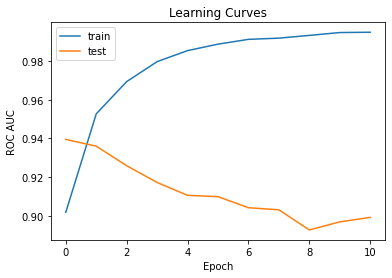

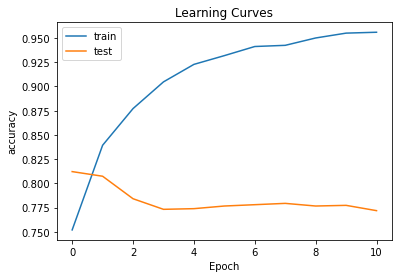

In [2]:
import matplotlib.pyplot as plt

def print_results(hist, accuracy_curve=False):
    print("Highest val_auc: ", str(max(hist.history['val_auc'])))
    print("Highest val_accuracy: ", str(max(hist.history['val_accuracy'])))
    plt.title('Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.plot(hist.history['auc'], label='train')
    plt.plot(hist.history['val_auc'], label='test')
    plt.legend()
    plt.show()
    if accuracy_curve==True:
        plt.title('Learning Curves')
        plt.xlabel('Epoch')
        plt.ylabel('accuracy')
        plt.plot(hist.history['accuracy'], label='train')
        plt.plot(hist.history['val_accuracy'], label='test')
        plt.legend()
        plt.show()

print_results(hist, accuracy_curve=True)